## Assessing Accuracy

#### Set Up Script

In [1]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import tensorflow as tf
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as patches

# Root directory of the project
ROOT_DIR = os.path.abspath("../../")

# Root directory of MRCNN
MASK_RCNN_DIR = os.path.abspath("../../Mask_RCNN/")

# Import Mask RCNN
sys.path.append(MASK_RCNN_DIR)  # To find local version of the library
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
import mrcnn.model as modellib
from mrcnn.model import log

import oyster

%matplotlib inline 

# Directory to save logs and trained model
MODEL_DIR = os.path.join(ROOT_DIR, "logs")

Using TensorFlow backend.


## Configurations

In [2]:
config = oyster.OysterConfig()
OYSTER_DIR = "../data/2kx2k_dataset/"

In [3]:
# Override the training configurations with a few
# changes for inferencing.
class InferenceConfig(config.__class__):
    # Run detection on one image at a time
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

config = InferenceConfig()
config.display()


Configurations:
BACKBONE                       resnet101
BACKBONE_STRIDES               [4, 8, 16, 32, 64]
BATCH_SIZE                     1
BBOX_STD_DEV                   [0.1 0.1 0.2 0.2]
COMPUTE_BACKBONE_SHAPE         None
DETECTION_MAX_INSTANCES        100
DETECTION_MIN_CONFIDENCE       0.02
DETECTION_NMS_THRESHOLD        0.3
FPN_CLASSIF_FC_LAYERS_SIZE     1024
GPU_COUNT                      1
GRADIENT_CLIP_NORM             5.0
IMAGES_PER_GPU                 1
IMAGE_CHANNEL_COUNT            3
IMAGE_MAX_DIM                  1024
IMAGE_META_SIZE                14
IMAGE_MIN_DIM                  800
IMAGE_MIN_SCALE                0
IMAGE_RESIZE_MODE              square
IMAGE_SHAPE                    [1024 1024    3]
LEARNING_MOMENTUM              0.9
LEARNING_RATE                  0.001
LOSS_WEIGHTS                   {'mrcnn_mask_loss': 2.0, 'mrcnn_class_loss': 1.0, 'rpn_class_loss': 1.0, 'rpn_bbox_loss': 1.0, 'mrcnn_bbox_loss': 1.0}
MASK_POOL_SIZE                 14
MASK_SHAPE        

## Notebook Preferences

In [4]:
# Device to load the neural network on.
# Useful if you're training a model on the same 
# machine, in which case use CPU and leave the
# GPU for training.
DEVICE = "/cpu:0"  # /cpu:0 or /gpu:0

# Inspect the model in training or inference modes
# values: 'inference' or 'training'
# TODO: code for 'training' test mode not ready yet
TEST_MODE = "inference"

In [5]:
def get_ax(rows=1, cols=1, size=16):
    """Return a Matplotlib Axes array to be used in
    all visualizations in the notebook. Provide a
    central point to control graph sizes.
    
    Adjust the size attribute to control how big to render images
    """
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

### Load Dataset

In [6]:
# Load validation dataset
dataset_test = oyster.OysterDataset()
dataset_test.load_oyster(OYSTER_DIR, "test")

# Must call before using the dataset
dataset_test.prepare()

print("Images: {}\nClasses: {}".format(len(dataset_test.image_ids), dataset_test.class_names))

Images: 66
Classes: ['BG', 'oyster']


### Load Model

In [7]:
# Create model in inference mode
with tf.device(DEVICE):
    model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR,
                              config=config)
    
# Set path to oyster weights file

# Download file from the Releases page and set its path
# https://github.com/matterport/Mask_RCNN/releases
# weights_path = "/path/to/mask_rcnn_balloon.h5"

# Or, load the last model you trained
#weights_path = model.find_last()

#weights_path = '../../logs/oyster20181225T2210/mask_rcnn_oyster_0024.h5'
#weights_path = '../../logs/oyster20190106T0103/mask_rcnn_oyster_0025.h5'
weights_path = MASK_RCNN_DIR + '/logs/oyster20190109T1451/mask_rcnn_oyster_0180.h5'
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Instructions for updating:
Create a `tf.sparse.SparseTensor` and use `tf.sparse.to_dense` instead.
Loading weights  /host/Code/Mask_RCNN/logs/oyster20190109T1451/mask_rcnn_oyster_0180.h5
Re-starting from epoch 180


In [8]:
def compute_overlaps_masks(masks1, masks2):
    """Computes IoU overlaps between two sets of masks.
    masks1, masks2: [Height, Width, instances]
    """
        
    # If either set of masks is empty return empty result
    if masks2.shape[-1] == 0:
        overlaps = 0
        intersections = 0
        area2 = 0
        masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
        area1 = np.sum(masks1, axis=0)
        union = area2
        return(overlaps, intersections, union, area1, area2)
    if masks1.shape[-1] == 0:
        return(-1)
    # flatten masks and compute their areas
    masks1 = np.reshape(masks1 > .5, (-1, masks1.shape[-1])).astype(np.float32)
    masks2 = np.reshape(masks2 > .5, (-1, masks2.shape[-1])).astype(np.float32)
    area1 = np.sum(masks1, axis=0)
    area2 = np.sum(masks2, axis=0)

    # intersections and union
    intersections = np.dot(masks1.T, masks2)
    union = area1[:, None] + area2[None, :] - intersections
    overlaps = intersections / union

    return(overlaps, intersections, union, area1, area2)

def calculate_metrics(dataset, prediction_threshold=0.5):
    total_gt = 0  # total ground truth reefs
    total_predicted = 0 # total predicted reefs
    total_tp = 0 # total true positives
    total_fp = 0 # total false positives
    total_px = 0 # all pixels
    total_fn = 0

    for image_id in dataset.image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]
        
        # filter out masks that don't meet a prediction threshold
        r['masks'] = np.array(r['masks'][:,:, r['scores'] > prediction_threshold])

        overlap, intersection, union, gt_area, mask_area = compute_overlaps_masks(gt_mask, r['masks'])
            
        total_tp += np.sum(intersection)
        total_predicted += np.sum(mask_area)
        total_gt += np.sum(gt_mask)

        total_fp += np.sum(mask_area) - np.sum(intersection) 

        total_fn += np.sum(gt_mask) - np.sum(intersection) 

        length, width, instances = gt_mask.shape
        total_px += length * width
        
    total_tn = total_px - total_predicted
    return(total_tp, total_fp, total_fn, total_tn, total_gt, total_predicted, total_px)

def calc_prec_recall_acc(total_tp, total_fp, total_fn, total_tn):
    precision = total_tp / (total_tp + total_fp)
    recall = total_tp / (total_tp + total_fn)
    acc = (total_tp + total_tn) / total_px
    return(precision, recall, acc)

In [9]:
total_tp, total_fp, total_fn, total_tn, total_gt, total_predicted, total_px = calculate_metrics(dataset_test, prediction_threshold=0.98)
precision, recall, acc = calc_prec_recall_acc(total_tp, total_fp, total_fn, total_tn)

In [10]:
total_gt, total_predicted

(4847769, 5230570.0)

In [12]:
5230570 / 4847769

1.078964364844942

In [11]:
np.arange(0.991, 1.000, 0.001)

array([0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999,
       1.   ])

In [49]:
pra_list_extd = []
for confidence in np.arange(0.991, 1.000, 0.001):
    total_tp, total_fp, total_fn, total_tn, total_gt, total_predicted, total_px = calculate_metrics(dataset_test, prediction_threshold=confidence)
    precision, recall, acc = calc_prec_recall_acc(total_tp, total_fp, total_fn, total_tn)
    pra_list_extd.append([precision, recall, acc])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in long_scalars


In [24]:
pra_list = []
for confidence in np.arange(0.0, 1.01, 0.01):
    total_tp, total_fp, total_fn, total_tn, total_gt, total_predicted, total_px = calculate_metrics(dataset_test, prediction_threshold=confidence)
    precision, recall, acc = calc_prec_recall_acc(total_tp, total_fp, total_fn, total_tn)
    pra_list.append([precision, recall, acc])

/usr/local/lib/python3.5/dist-packages/ipykernel_launcher.py:68: RuntimeWarning: invalid value encountered in long_scalars


In [44]:
np.arange(0.0, 1.01, 0.01)

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [48]:
np.arange(0.991, 1.0, 0.001)

array([0.991, 0.992, 0.993, 0.994, 0.995, 0.996, 0.997, 0.998, 0.999,
       1.   ])

In [51]:
pra_list + pra_list_extd

[[0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.859789936360416

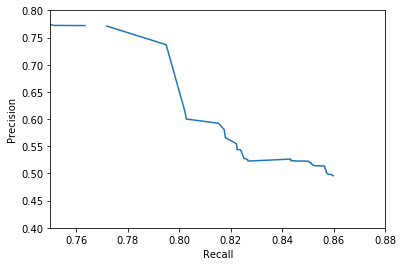

In [50]:
fig, ax = plt.subplots()
pra_array = np.array(pra_list + pra_list_extd)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.75,0.88)
ax.set_ylim(0.4,0.8)
ax.plot([i[1] for i in pra_array], [i[0] for i in pra_array])

In [2]:
pra_list_extd = [[0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49577102290717734, 0.8597899363604166, 0.9387456287037242],
 [0.49826806836007903, 0.8588532168096293, 0.9394204977786902],
 [0.4983325385052279, 0.8578985508591684, 0.9395034385449959],
 [0.501673212813713, 0.8570629087318311, 0.9403646064527107],
 [0.5018699135434502, 0.8570629087318311, 0.9404115098895449],
 [0.505630170431188, 0.8570629087318311, 0.9413011290810325],
 [0.5062049918937132, 0.8570629087318311, 0.9414359583999171],
 [0.5094026068977108, 0.8565932081334734, 0.9422121192469741],
 [0.509815683535026, 0.8565932081334734, 0.9423075589266691],
 [0.5108457061214378, 0.8565917641702813, 0.9425449660330107],
 [0.5124131162073503, 0.8565917641702813, 0.9429042556069114],
 [0.5124888772055838, 0.8565917641702813, 0.9429215662407152],
 [0.5129133277193354, 0.8565088394269611, 0.943023970632842],
 [0.513745716164679, 0.8561688892354401, 0.9432360331217448],
 [0.5142436584935329, 0.8527623737847245, 0.9435744719071821],
 [0.5147026477669158, 0.8524669801717037, 0.9436975681420529],
 [0.5146509822816958, 0.8522388339873456, 0.9437009926998254],
 [0.5184055373219818, 0.8511507045818396, 0.9446119106177128],
 [0.5195689807579077, 0.8511507045818396, 0.944869446031975],
 [0.5198767936350099, 0.8509157511424328, 0.9449525890928326],
 [0.5213232530339293, 0.8502993851398447, 0.9453103470079827],
 [0.521547982343521, 0.8502993851398447, 0.9453595768321644],
 [0.522358468975337, 0.8502993851398447, 0.9455367724100748],
 [0.5229458666968412, 0.8475096482526292, 0.9458431186098041],
 [0.5229098382984704, 0.8473644268115911, 0.9458445780205004],
 [0.5226390998785617, 0.8462296780230246, 0.9458583773988666],
 [0.5233873102125619, 0.8444179167778003, 0.946136084469882],
 [0.523082513077082, 0.8433764067553549, 0.9461367491519812],
 [0.5263678019242289, 0.8433764067553549, 0.9468416589679141],
 [0.5227479598058069, 0.8266650081718002, 0.9471331943165172],
 [0.5249494662766402, 0.826662739086784, 0.9475978938016024],
 [0.5266478494938287, 0.8260820596030876, 0.9479901862866951],
 [0.5271538194129302, 0.8254964293884465, 0.948132442705559],
 [0.5274815730744189, 0.8252391976597895, 0.948216741735285],
 [0.5275695133603141, 0.8250966578646796, 0.9482439503525243],
 [0.5304626379835892, 0.8249415349617525, 0.9488510652021929],
 [0.5424896281790823, 0.8239272539595018, 0.9513260667974298],
 [0.5436792567406756, 0.8236904439959908, 0.951572779453162],
 [0.5438055450492113, 0.8224271824833238, 0.9516716581402402],
 [0.5494440632437061, 0.8224271824833238, 0.9527588179617217],
 [0.5520799286922744, 0.8222984634787672, 0.9532667362328732],
 [0.5548394632198457, 0.8221441656976642, 0.9537943204243978],
 [0.5660258847112098, 0.8179205733606532, 0.956072474970962],
 [0.5747801186099395, 0.8176563280964914, 0.9576278310833555],
 [0.5809299864103944, 0.8174378770935661, 0.9586937644264915],
 [0.5923847015295083, 0.815206747681253, 0.9607072454510313],
 [0.6000821251509586, 0.8027748434382909, 0.962524110620672],
 [0.6143251576482007, 0.8021879755409138, 0.9647225466641512],
 [0.7368478113513699, 0.7949262846476389, 0.9801136941620798],
 [0.7710985041286379, 0.7718812509424439, 0.983949545657996],
 [0.7719934324830091, 0.7634144696250997, 0.9842059973514441],
 [0.7722916076358077, 0.7511480023078657, 0.9844860886082505],
 [0.7738370965823129, 0.7500609043046399, 0.9846444129943848],
 [0.7883797727233589, 0.746044623825929, 0.985972361131148],
 [0.788711724711156, 0.7140655835705043, 0.9866003556685015],
 [0.7964007114683628, 0.7073094860749347, 0.9873336300705419],
 [0.7987396444022362, 0.6880763089165346, 0.9878552754720052],
 [0.8098594139655522, 0.6721729108792106, 0.9889453685644901],
 [0.8720170680207316, 0.48234950964041395, 0.9950410813996287]]

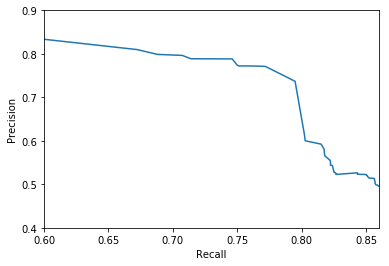

In [10]:
import matplotlib.pyplot as plt
import numpy as np
fig, ax = plt.subplots()
pra_array = np.array(pra_list_extd)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.6,.86)
ax.set_ylim(0.4,.9)
ax.plot([i[1] for i in pra_array], [i[0] for i in pra_array])

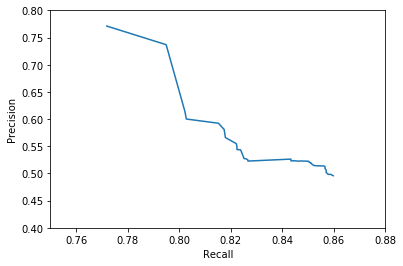

In [35]:
fig, ax = plt.subplots()
pra_array = np.array(pra_list)
ax.set_xlabel("Recall")
ax.set_ylabel("Precision")
ax.set_xlim(0.75,0.88)
ax.set_ylim(0.4,0.8)
ax.plot([i[1] for i in pra_array], [i[0] for i in pra_array])

In [1]:
pra_list

NameError: name 'pra_list' is not defined

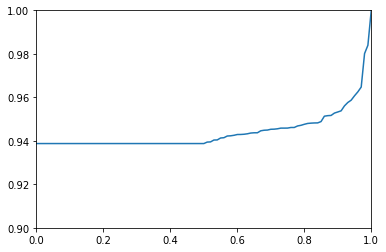

In [30]:
fig, ax = plt.subplots()
pra_array = np.array(pra_list)
ax.set_xlim(0,1)
ax.set_ylim(0.9,1)
ax.plot(np.arange(0.0, 1.01, 0.01),[i[2] for i in pra_array])

In [323]:
precision, recall, acc # 0.999

(0.8720170680207316, 0.48234950964041395, 0.9950410813996287)

In [321]:
precision, recall, acc # 0.99

(0.7710985041286379, 0.7718812509424439, 0.983949545657996)

In [319]:
precision, recall, acc # 0.98

(0.7368478113513699, 0.7949262846476389, 0.9801136941620798)

In [317]:
precision, recall, acc # 0.95

(0.5923847015295083, 0.815206747681253, 0.9607072454510313)

In [313]:
precision, recall, acc # 0.9

(0.5520799286922744, 0.8222984634787672, 0.9532667362328732)

In [303]:
precision, recall, acc # 0.5

(0.5213232530339293, 0.8502993851398447, 0.9453103470079827)

In [ ]:
precision, recall, acc # 0.1

In [295]:
#image_ids = np.random.choice(dataset_test.image_ids, 53)

APs = []
AP_ranges = []
precisions_list = []
recalls_list = []

total_gt = 0  # total ground truth reefs
total_predicted = 0 # total predicted reefs
total_tp = 0 # total true positives

for image_id in dataset_test.image_ids:
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset_test, config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]

    # Compute AP
    AP, precisions, recalls, overlaps =\
        utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                         r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    precisions_list.append(precisions)
    recalls_list.append(recalls)
    """
    AP_range = utils.compute_ap_range(gt_bbox, gt_class_id, gt_mask,
                     r["rois"], r["class_ids"], r["scores"], r['masks'],
                     iou_thresholds=None, verbose=0)
    AP_ranges.append(AP_range)
    """
    gt_match, pred_match, overlaps = utils.compute_matches(gt_bbox, gt_class_id, gt_mask,
                    r["rois"], r["class_ids"], r["scores"], r['masks'],
                    iou_threshold=0.5, score_threshold=0.5)
    
    total_gt += gt_match.shape[0]  # total ground truth reefs
    total_predicted += pred_match.shape[0] # total predicted reefs
    total_tp += (pred_match > -1).sum() # total true positives
    
    break

print("mAP: ", np.mean(APs))

mAP:  1.0


In [296]:
r['masks']

array([[[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       [[False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        ...,
        [False, False, False, False, False, False],
        [False, False, False, False, False, False],
        [False, False, False, False, False, False]],

       ...,

      

In [ ]:
r['masks'][0]

In [292]:
r['masks'] = np.array(r['masks'][:,:, r['scores'] > 0.6])

In [38]:
total_gt, total_predicted, total_tp

(262, 373, 167)

In [39]:
total_fp = total_predicted - total_tp
total_fn = total_gt - total_tp

# Precision is defined as the number of true positives over the number of true positives plus the number of false positives.

precision = total_tp / (total_tp + total_fp)

# Recall is defined as the number of true positives over the number of true positives plus the number of false negatives.
recall = total_tp / (total_tp + total_fn )

In [40]:
precision, recall # with iou_thresh = 0.5 and score_thresh = 0.5

(0.4477211796246649, 0.6374045801526718)

In [28]:
precision, recall # with iou_thresh = 0.5 and score_thresh = 0.1

(0.4477211796246649, 0.6374045801526718)

In [32]:
precision, recall # with iou_thresh = 0.05 and score_thresh = 0.1

(0.5040214477211796, 0.7175572519083969)

In [24]:
precision, recall # with iou_thresh = 0.1 and score_thresh = 0.1

(0.5040214477211796, 0.7175572519083969)

In [36]:
precision, recall # with iou_thresh = 0.1 and score_thresh = 0.25

(0.4932975871313673, 0.7022900763358778)

In [19]:
precision, recall # with iou_thresh = 0.1 and score_thresh = 0.5

(0.4477211796246649, 0.6374045801526718)

In [45]:
pre_flat = np.concatenate(precisions_list, axis=0 )

In [46]:
rec_flat = np.concatenate(recalls_list, axis=0 )

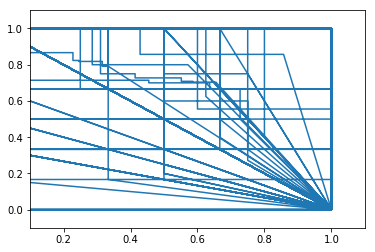

In [49]:
plot_precision_recall_custom(APs[0], pre_flat, rec_flat)

In [48]:
def plot_precision_recall_custom(AP, precisions, recalls):
    """Draw the precision-recall curve.
    AP: Average precision at IoU >= 0.5
    precisions: list of precision values
    recalls: list of recall values
    """
    # Plot the Precision-Recall curve
    _, ax = plt.subplots(1)
    #ax.set_title("Precision-Recall Curve. AP@50 = {:.3f}".format(AP))
    ax.set_ylim(-0.1, 1.1)
    ax.set_xlim(0.1, 1.1)
    _ = ax.plot(recalls, precisions)

In [29]:
APs[-1]

0.6666666666666666

In [ ]:
So I can calculate total precision

In [56]:
def calculate_metrics(dataset, score_threshold=0.5, iou_threshold=0.5):
    
    total_gt = 0  # total ground truth reefs
    total_predicted = 0 # total predicted reefs
    total_tp = 0 # total true positives

    for image_id in dataset.image_ids:
        # Load image and ground truth data
        image, image_meta, gt_class_id, gt_bbox, gt_mask =\
            modellib.load_image_gt(dataset, config,
                                   image_id, use_mini_mask=False)
        molded_images = np.expand_dims(modellib.mold_image(image, config), 0)
        # Run object detection
        results = model.detect([image], verbose=0)
        r = results[0]

        gt_match, pred_match, overlaps = utils.compute_matches(gt_bbox, gt_class_id, gt_mask,
                        r["rois"], r["class_ids"], r["scores"], r['masks'],
                        iou_threshold=iou_threshold, score_threshold=score_threshold)

        total_gt += gt_match.shape[0]  # total ground truth reefs
        total_predicted += pred_match.shape[0] # total predicted reefs
        total_tp += (pred_match > -1).sum() # total true positives

    total_fp = total_predicted - total_tp
    total_fn = total_gt - total_tp

    # Precision is defined as the number of true positives over the number of true positives plus the number of false positives.
    precision = total_tp / (total_tp + total_fp)

    # Recall is defined as the number of true positives over the number of true positives plus the number of false negatives.
    recall = total_tp / (total_tp + total_fn )
    
    return(total_tp, total_predicted, total_fp, precision, recall)

In [67]:
def calculate_roc(dataset, score_thresholds=None, iou_threshold=0.5):
    # The ROC plot uses 1 – specificity on the x-axis and sensitivity on the y-axis
    # False positive rate (FPR) is identical with 1 – specificity, and true positive rate (TPR) 
    # is identical with sensitivity.
    
    score_thresholds = score_thresholds or np.arange(0.0, 0.1, 0.05)
    
    fprs = []
    tprs = []
    
    for threshold in score_thresholds:
    
        total_tp, total_predicted, total_fp, precision, recall = calculate_metrics(dataset, 
                                                                                   score_threshold=threshold, 
                                                                                   iou_threshold=iou_threshold)
        fpr = total_fp / total_predicted
        tpr = recall
        
        fprs.append(fpr)
        tprs.append(tpr)
    
    return(tprs, fprs)
    
    

In [68]:
true_pos_low, false_pos_low = calculate_roc(dataset_test)

In [69]:
true_pos_low, false_pos_low

([0.6374045801526718, 0.6374045801526718],
 [0.5522788203753352, 0.5522788203753352])

In [63]:
np.arange(0.1, 1.0, 0.05, score_threholds=np.arange(0.0, 0.1, 0.05))

array([0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 , 0.55, 0.6 ,
       0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95])

In [59]:
true_pos

[0.6374045801526718,
 0.6374045801526718,
 0.6374045801526718,
 0.6374045801526718,
 0.6374045801526718,
 0.6374045801526718,
 0.6374045801526718,
 0.6374045801526718,
 0.6374045801526718,
 0.6183206106870229,
 0.5992366412213741,
 0.5229007633587787,
 0.4770992366412214,
 0.4198473282442748,
 0.2786259541984733,
 0.16030534351145037,
 0.061068702290076333,
 0.0]

In [62]:
false_pos

[0.5522788203753352,
 0.5522788203753352,
 0.5522788203753352,
 0.5522788203753352,
 0.5522788203753352,
 0.5522788203753352,
 0.5522788203753352,
 0.5522788203753352,
 0.5522788203753352,
 0.5656836461126006,
 0.579088471849866,
 0.6327077747989276,
 0.6648793565683646,
 0.7050938337801609,
 0.8042895442359249,
 0.8873994638069705,
 0.9571045576407506,
 1.0]

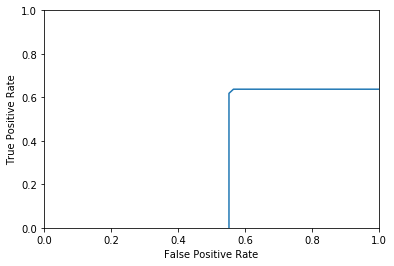

In [76]:
fig, ax = plt.subplots()
ax.set_xlim(0,1)
ax.set_ylim(0,1)
ax.set_xlabel("False Positive Rate")
ax.set_ylabel("True Positive Rate")

ax.plot(list(reversed(false_pos)), true_pos)